# Script to work with fixed macrophages

In [45]:
### conda install seaborn scikit-learn statsmodels numba pytables
### conda install -c conda-forge python-igraph louvain
### pip install scanpy

import pickle,numpy,pandas
import matplotlib,matplotlib.pyplot
import scipy,scipy.stats
import scanpy
scanpy.settings.verbosity=5

## 1. Read data files

In [2]:
### define input files
adata=scanpy.read_10x_mtx('/Volumes/omics4tb2/alomana/projects/i18/results/both_aggregated/outs/filtered_feature_bc_matrix',var_names='gene_symbols',cache=True)
adata.var_names_make_unique() 
adata

... reading from cache file ./cache/Volumes-omics4tb2-alomana-projects-i18-results-both_aggregated-outs-filtered_feature_bc_matrix-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


View of AnnData object with n_obs × n_vars = 1274 × 112137 
    var: 'gene_ids', 'feature_types'

## 2. Preprocess

In [3]:
scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

filtered out 9 cells that have less than 200 genes expressed
filtered out 84118 genes that are detected in less than 3 cells


### 2.1. Retrieve mouse cells only

In [4]:
cellIDs=adata.obs_names.tolist()
geneNames=adata.var_names.tolist()

jarFile='/Volumes/omics4tb2/alomana/projects/i18/results/jarFiles/species.cellIDs.run.006.pickle'
f=open(jarFile,'rb')
[mouseCellIDs,humanCellIDs,chimericCellIDs]=pickle.load(f)
f.close()

print(len(cellIDs),len(geneNames))
print('mouse',len(mouseCellIDs))
print('human',len(humanCellIDs))
print('chimeric',len(chimericCellIDs))

1265 28019
mouse 196
human 1024
chimeric 45


In [5]:
# slice in mouse cells
print('before slicing mouse cells...')
print(adata)
print()
adata=adata[mouseCellIDs,:]
print('after')
print(adata)

# slice in mouse genes
mouseGenes=[element for element in geneNames if element[:4] == 'mm10']
print()
print('before slicing mouse genes...')
print(adata)
print()
adata=adata[:,mouseGenes]
print('after')
print(adata)

before slicing mouse cells...
AnnData object with n_obs × n_vars = 1265 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

after
View of AnnData object with n_obs × n_vars = 196 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

before slicing mouse genes...
View of AnnData object with n_obs × n_vars = 196 × 28019 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

after
View of AnnData object with n_obs × n_vars = 196 × 10891 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


### 2.2. Highly abundant genes

    normalizing by total count per cell
        finished (0:00:00.01): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


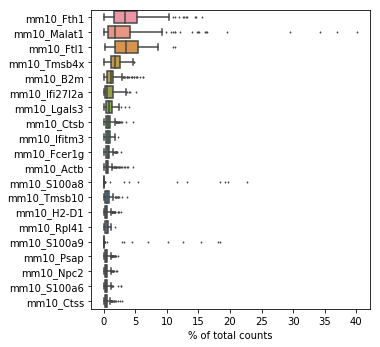

In [6]:
scanpy.pl.highest_expr_genes(adata,n_top=20)

### 2.3. QC based on mitochondrial genes and number of counts

... storing 'feature_types' as categorical


['mm10_mt-Rnr1', 'mm10_mt-Rnr2', 'mm10_mt-Nd1', 'mm10_mt-Nd2', 'mm10_mt-Co1', 'mm10_mt-Co2', 'mm10_mt-Atp8', 'mm10_mt-Atp6', 'mm10_mt-Co3', 'mm10_mt-Nd3', 'mm10_mt-Nd4', 'mm10_mt-Nd5', 'mm10_mt-Cytb']


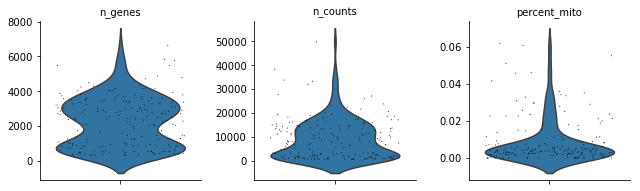

In [7]:
mitoGenes=[element for element in adata.var_names if element[:8] == 'mm10_mt-']
print(mitoGenes)

adata.obs['percent_mito']=numpy.sum(adata[:,mitoGenes].X,axis=1).A1/numpy.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.pl.violin(adata,['n_genes','n_counts','percent_mito'],jitter=0.4,multi_panel=True)

AnnData object with n_obs × n_vars = 196 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'


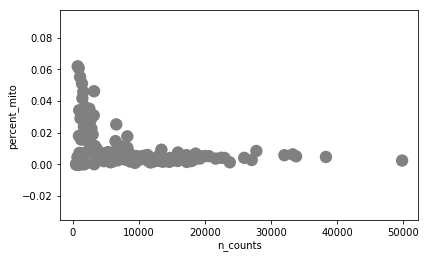

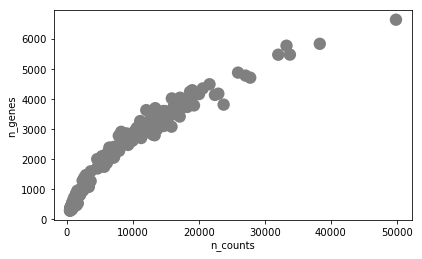

In [8]:
print(adata)
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

remove high mito
View of AnnData object with n_obs × n_vars = 192 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove top outliers
View of AnnData object with n_obs × n_vars = 187 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove low n_count
View of AnnData object with n_obs × n_vars = 81 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove low n_genes
View of AnnData object with n_obs × n_vars = 81 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



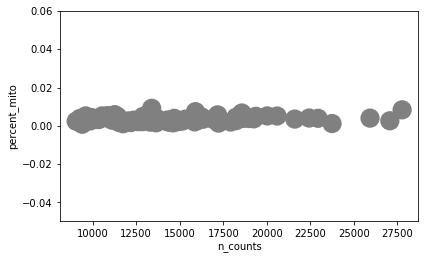

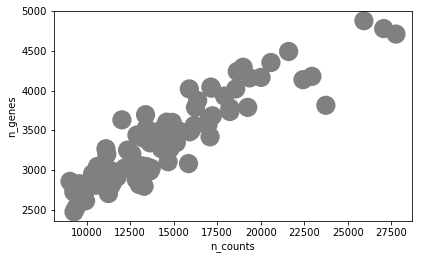

In [9]:
print('remove high mito')
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)
print()

print('remove top outliers')
adata = adata[adata.obs['n_counts'] < 30000, :]
print(adata)
print()

print('remove low n_count')
adata = adata[adata.obs['n_counts'] > 9000, :]
print(adata)
print()

print('remove low n_genes')
adata = adata[adata.obs['n_genes'] > 2000, :]
print(adata)
print()

scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

### 2.4. Normalization and log transform

In [10]:
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=30e3)

    normalizing by total count per cell
        finished (0:00:00.00): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [11]:
scanpy.pp.log1p(adata)

In [12]:
adata.raw = adata

    extracting highly variable genes
    Gene indices [8850] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:00.44)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


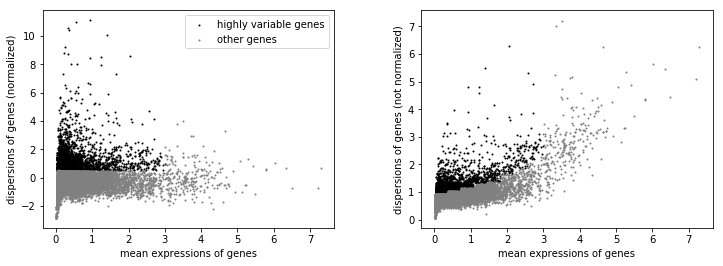

In [13]:
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [14]:
print(adata)
adata = adata[:,adata.var['highly_variable']]
print(adata)

AnnData object with n_obs × n_vars = 81 × 10891 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
View of AnnData object with n_obs × n_vars = 81 × 2292 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


### 2.5. Regress out effects of total counts per cell and the percentage of mitochondrial genes  

In [15]:
scanpy.pp.regress_out(adata,['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.96)


In [16]:
scanpy.pp.scale(adata,max_value=10)

    ... clipping at max_value 10


### 2.6. Associate treatment to cell ID

In [17]:
cellIDs=adata.obs_names.tolist()
print(len(cellIDs))

cellConditions=[]
for cellID in cellIDs:
    if '-1' in cellID: 
        cellConditions.append('fixed')
    elif '-2' in cellID:
        cellConditions.append('fresh')
    else:
        raise ValueError('cellID not recognized')
    
print(cellConditions,len(cellConditions))
print('number of fixed cells:',cellConditions.count('fixed'))
print('number of fresh cells:',cellConditions.count('fresh'))
observedRatio=cellConditions.count('fixed')/cellConditions.count('fresh')
expectedRatio=413/861
print('observed ratio:{:.3f}, expected ratio:{:3f}'.format(observedRatio,expectedRatio))

81
['fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fixed', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh', 'fresh'] 81
number of fixed cells: 24
number of fresh cells: 57
observed ratio:0.421, expected ratio:0.479675


## 3. Visualization

## 3.1. PCA

In [18]:
scanpy.tl.pca(adata, svd_solver='arpack')

    computing PCA with n_comps = 50
        finished (0:00:00.37)     and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


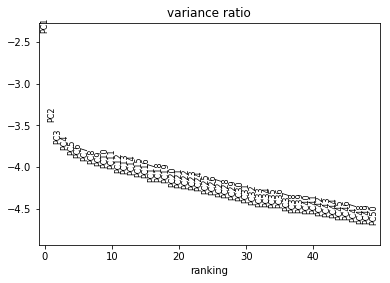

In [19]:
scanpy.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

... storing 'treatment' as categorical


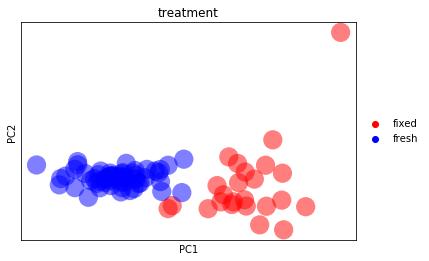

In [20]:
adata.obs['treatment']=cellConditions
scanpy.pl.pca(adata,color='treatment',palette=['red','blue'],alpha=0.5)

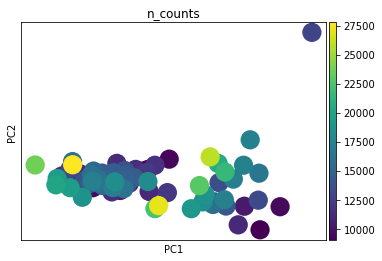

In [21]:
scanpy.pl.pca(adata,color='n_counts',palette='viridis')

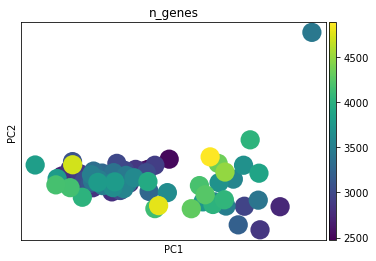

In [22]:
scanpy.pl.pca(adata,color='n_genes',palette='viridis')

## 3.2. tSNE

In [23]:
scanpy.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 80 nearest neighbors...
[t-SNE] Indexed 81 samples in 0.000s...
[t-SNE] Computed neighbors for 81 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 81 / 81
[t-SNE] Mean sigma: 15.524231
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 68.2342453, gradient norm = 0.0444042 (50 iterations in 0.014s)
[t-SNE] Iteration 100: error = 74.8307419, gradient norm = 0.0208042 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 82.2939682, gradient norm = 0.1543713 (50 iterations in 0.013s)
[t-SNE] Iteration 200: error = 76.7095490, gradient norm = 0.0858548 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 84.7307816, gradient norm = 0.0272348 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.730782
[t-SNE] Iteration 300: error = 2.6548109, gradient norm = 0

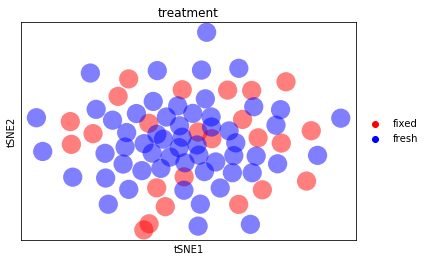

In [24]:
scanpy.pl.tsne(adata,color='treatment',palette=['red','blue'],alpha=0.5)

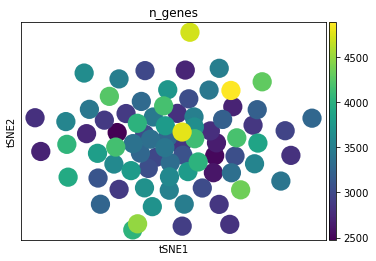

In [25]:
scanpy.pl.tsne(adata,color='n_genes',palette='viridis')

## 3.3. UMAP

computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:00.00)
    computed connectivities (0:00:03.13)
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished (0:00:01.22) --> added
    'X_umap', UMAP coordinates (adata.obsm)


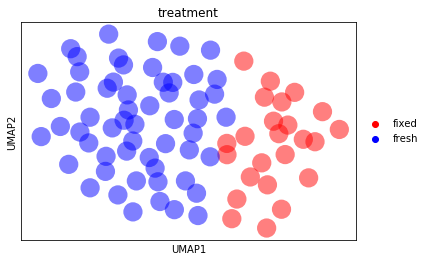

In [26]:
scanpy.pp.neighbors(adata, n_neighbors=40, n_pcs=50)
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color='treatment',alpha=0.5)

## 3.4 Louvain

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


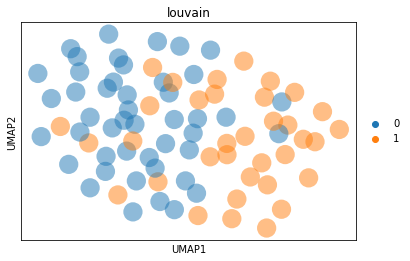

In [27]:
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata, color=['louvain'],alpha=0.5)

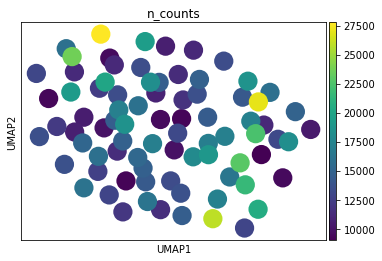

In [28]:
scanpy.pl.umap(adata, color='n_counts',palette='viridis')

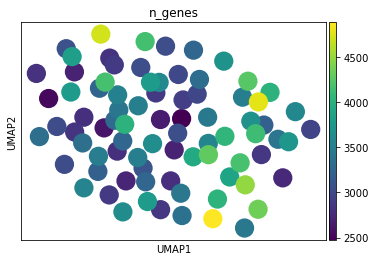

In [29]:
scanpy.pl.umap(adata, color='n_genes',palette='viridis')

# 4. Find markers

ranking genes
    consider 'louvain' groups: ['0' '1']
    with sizes: [46 35]
    finished (0:00:00.09) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


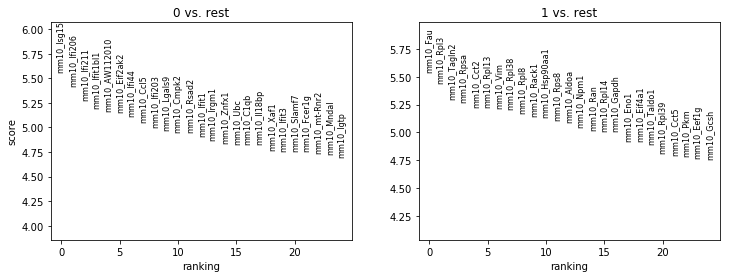

In [30]:
scanpy.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [31]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(10)

,0_n,0_p,0_l,1_n,1_p,1_l
0,mm10_Isg15,0.000110,0.743590,mm10_Fau,0.000110,0.203145
1,mm10_Ifi206,0.000133,1.651021,mm10_Rpl3,0.000133,0.940844
2,mm10_Ifi211,0.000167,1.035170,mm10_Tagln2,0.000167,0.820974
3,mm10_Ifit1bl1,0.000167,1.485155,mm10_Rpsa,0.000167,0.569597
4,mm10_AW112010,0.000167,1.574792,mm10_Cct2,0.000167,1.781696
5,mm10_Eif2ak2,0.000167,1.673853,mm10_Rpl13,0.000167,0.354508
6,mm10_Ifi44,0.000175,1.646735,mm10_Vim,0.000167,0.348172
7,mm10_Ccl5,0.000211,1.916865,mm10_Rpl38,0.000167,0.737755
8,mm10_Ifi203,0.000225,0.991871,mm10_Rpl8,0.000167,0.342127
9,mm10_Lgals9,0.000252,0.687935,mm10_Rack1,0.000167,0.718846


ranking genes
    consider 'louvain' groups: ['1' '0']
    with sizes: [35 46]
    finished (0:00:00.08) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


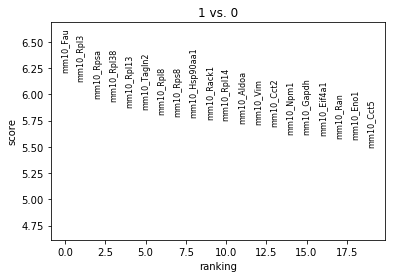

In [32]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['1'], reference='0', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

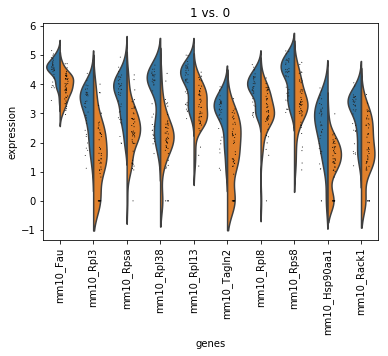

In [33]:
scanpy.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

ranking genes
    consider 'treatment' groups: ['fixed' 'fresh']
    with sizes: [24 57]
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished (0:00:00.08) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


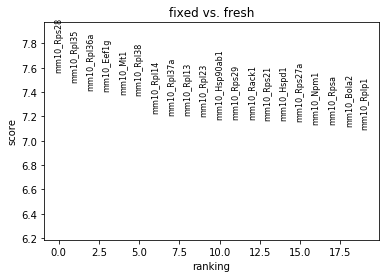

In [34]:
scanpy.tl.rank_genes_groups(adata, 'treatment', groups=['fixed'], reference='fresh', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['fixed'], n_genes=20)

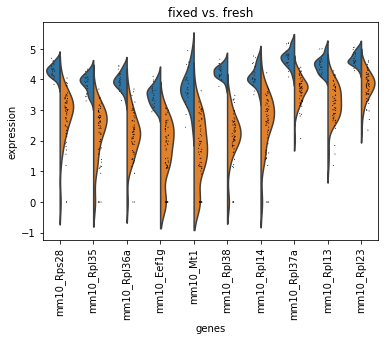

In [35]:
scanpy.pl.rank_genes_groups_violin(adata, groups='fixed', n_genes=10)

# 5. Quantifications comparing fixed and fresh

## 5.1 general expression

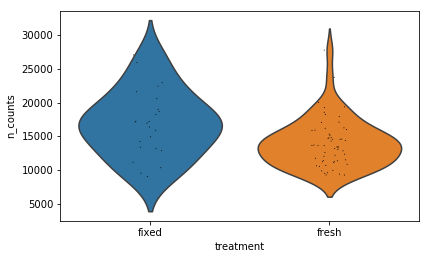

In [36]:
scanpy.pl.violin(adata,keys=['n_counts'],groupby='treatment',use_raw=True)

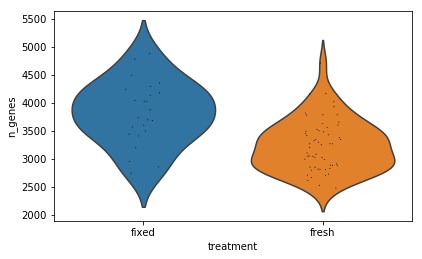

In [37]:
scanpy.pl.violin(adata,keys=['n_genes'],groupby='treatment',use_raw=True)

 # 5.2. expression correlation for fresh and fixed

81
2292
2292 2292
	 regression results:
		 slope -0.42105263010502797
		 intercept -7.296990164884498e-10
		 r_value -0.999999999999995
		 pvalue 0.0
		 std_err 8.795185689178827e-10
spearman -0.9999999810638737 0.0


Text(0, 0.5, 'Fresh')

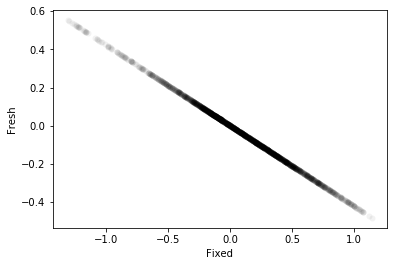

In [123]:
# 
# try the mean of expression of highly variable
# 

# what do I get within group?

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata[i,:].X
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=values[j]
        
        if '-1' in allCellIDs[i]:
            if geneID not in geneExpression['fixed']:
                geneExpression['fixed'][geneID]=[]
            geneExpression['fixed'][geneID].append(value)

        if '-2' in allCellIDs[i]:
            if geneID not in geneExpression['fresh']:
                geneExpression['fresh'][geneID]=[]
            geneExpression['fresh'][geneID].append(value)
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.mean(valuesx)
    averagey=numpy.mean(valuesy)
    
    #print(element)
    #print(valuesx,len(valuesx),averagex)
    #print(valuesy,len(valuesy),averagey)
    #print()
    
    x.append(averagex); y.append(averagey)
print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
#matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed')
matplotlib.pyplot.ylabel('Fresh')

81
2292
2292 2292
	 regression results:
		 slope 0.35852366253306733
		 intercept -0.022256887150988443
		 r_value 0.36200983755713845
		 pvalue 6.46243952645908e-72
		 std_err 0.019291980926715212
spearman 0.33989677889195175 4.379731390199381e-63


Text(0, 0.5, 'Fresh')

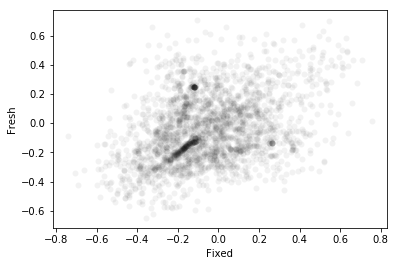

In [78]:
# 
# try the mean of expression two sets of fresh
# 

# what do I get within group?

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata[i,:].X
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=values[j]
        
        if i > 25 and i < 50:
            if geneID not in geneExpression['fixed']:
                geneExpression['fixed'][geneID]=[]
            geneExpression['fixed'][geneID].append(value)

        if i > 50 and i < 75:
            if geneID not in geneExpression['fresh']:
                geneExpression['fresh'][geneID]=[]
            geneExpression['fresh'][geneID].append(value)
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.mean(valuesx)
    averagey=numpy.mean(valuesy)
    
    #print(element)
    #print(valuesx,len(valuesx),averagex)
    #print(valuesy,len(valuesy),averagey)
    #print()
    
    x.append(averagex); y.append(averagey)
print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
#matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed')
matplotlib.pyplot.ylabel('Fresh')

81
2292
2292 2292
	 regression results:
		 slope 0.46641482200436635
		 intercept 0.03195453275626242
		 r_value 0.5169249229253453
		 pvalue 8.103305306181869e-157
		 std_err 0.016140481624309654
spearman 0.4700970776433722 2.3178670690658547e-126


Text(0, 0.5, 'Fresh')

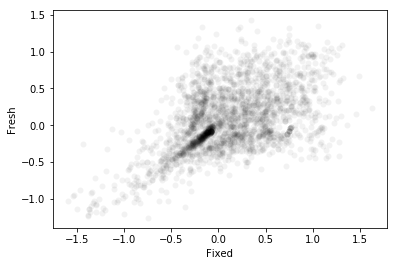

In [80]:
# 
# try the mean of expression two sets of fresh
# 

# what do I get within group?

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata[i,:].X
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=values[j]
        
        if i < 11:
            if geneID not in geneExpression['fixed']:
                geneExpression['fixed'][geneID]=[]
            geneExpression['fixed'][geneID].append(value)

        if i > 11 and i < 23:
            if geneID not in geneExpression['fresh']:
                geneExpression['fresh'][geneID]=[]
            geneExpression['fresh'][geneID].append(value)
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.mean(valuesx)
    averagey=numpy.mean(valuesy)
    
    #print(element)
    #print(valuesx,len(valuesx),averagex)
    #print(valuesy,len(valuesy),averagey)
    #print()
    
    x.append(averagex); y.append(averagey)
print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
#matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed')
matplotlib.pyplot.ylabel('Fresh')

81
2292
2292 2292
	 regression results:
		 slope nan
		 intercept nan
		 r_value nan
		 pvalue nan
		 std_err nan
spearman nan nan


/Users/alomana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log2
/Users/alomana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log2


Text(0, 0.5, 'Fresh')

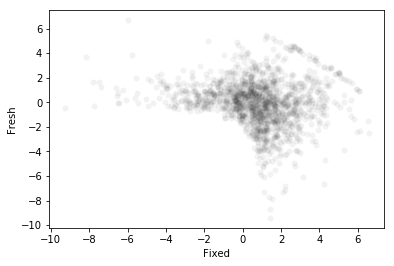

In [73]:
# 
# try the mean of expression of highly variable, reverted to counts
# 

# what do I get within group?

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata[i,:].X
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=values[j]
        
        if '-1' in allCellIDs[i]:
            if geneID not in geneExpression['fixed']:
                geneExpression['fixed'][geneID]=[]
            geneExpression['fixed'][geneID].append(value)

        if '-2' in allCellIDs[i]:
            if geneID not in geneExpression['fresh']:
                geneExpression['fresh'][geneID]=[]
            geneExpression['fresh'][geneID].append(value)
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.log2(numpy.mean(numpy.expm1(valuesx)))
    averagey=numpy.log2(numpy.mean(numpy.expm1(valuesy)))
    
    x.append(averagex); y.append(averagey)
print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
#matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed')
matplotlib.pyplot.ylabel('Fresh')

81
2292
2292 2292
	 regression results:
		 slope -0.24340879740966923
		 intercept -0.30550246012482024
		 r_value -0.38731738420063433
		 pvalue 6.4398848877896446e-83
		 std_err 0.012107576799691593
spearman 0.028593586786358732 0.17117241141273248


Text(0, 0.5, 'Fresh')

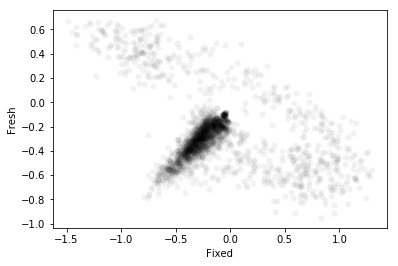

In [60]:
# 
# try the median of expression of highly variable
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata[i,:].X
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=values[j]
        
        if '-1' in allCellIDs[i]:
            if geneID not in geneExpression['fixed']:
                geneExpression['fixed'][geneID]=[]
            geneExpression['fixed'][geneID].append(value)

        if '-2' in allCellIDs[i]:
            if geneID not in geneExpression['fresh']:
                geneExpression['fresh'][geneID]=[]
            geneExpression['fresh'][geneID].append(value)
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.median(valuesx)
    averagey=numpy.median(valuesy)
    
    x.append(averagex); y.append(averagey)
print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# model
#satx=numpy.arange(0,4000,1)
#saty=slope*satx + intercept

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
#matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed')
matplotlib.pyplot.ylabel('Fresh')

81
10891
3003 3003
	 regression results:
		 slope 0.7856431886142854
		 intercept 0.5000433314280597
		 r_value 0.8295008985583979
		 pvalue 0.0
		 std_err 0.009656124394657097
spearman 0.7304687801815037 0.0


Text(0, 0.5, 'Fresh log2 average')

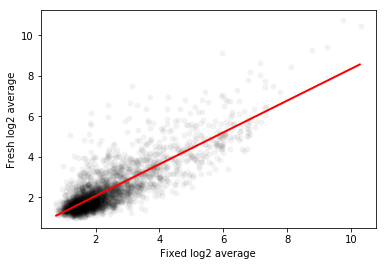

In [120]:
# 
# try the mean of raw expression
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=counts[0,j]
        
        if value > 0:
        
            if '-1' in allCellIDs[i]:
                if geneID not in geneExpression['fixed']:
                    geneExpression['fixed'][geneID]=[]
                geneExpression['fixed'][geneID].append(value)

            if '-2' in allCellIDs[i]:
                if geneID not in geneExpression['fresh']:
                    geneExpression['fresh'][geneID]=[]
                geneExpression['fresh'][geneID].append(value)        
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    # r_value 0.8295008985583979
    averagex=numpy.log2(numpy.mean(valuesx))
    averagey=numpy.log2(numpy.mean(valuesy))
    
    if len(valuesx) > 10 and len(valuesy) > 10:
        x.append(averagex); y.append(averagey)

print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# model
satx=numpy.arange(min(x),max(x),0.1)
saty=slope*satx + intercept

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed log2 average')
matplotlib.pyplot.ylabel('Fresh log2 average')

81
10891
3769 3769
	 regression results:
		 slope 0.9573272113621438
		 intercept 0.1513593288058659
		 r_value 0.962975212866196
		 pvalue 0.0
		 std_err 0.004366678099752356
spearman 0.8410815832546953 0.0


Text(0, 0.5, 'Fresh2 log2 average')

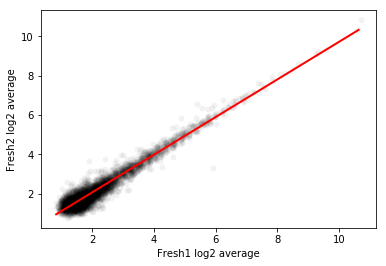

In [117]:
# 
# try the mean of raw expression
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=counts[0,j]
        
        if value > 0:
        
            if i > 25 and i < 50:
                if geneID not in geneExpression['fixed']:
                    geneExpression['fixed'][geneID]=[]
                geneExpression['fixed'][geneID].append(value)

            if i > 50 and i < 75:
                if geneID not in geneExpression['fresh']:
                    geneExpression['fresh'][geneID]=[]
                geneExpression['fresh'][geneID].append(value)        
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.log2(numpy.mean(valuesx))
    averagey=numpy.log2(numpy.mean(valuesy))
    
    if len(valuesx) > 5 and len(valuesy) > 5:
        x.append(averagex); y.append(averagey)

print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# model
satx=numpy.arange(min(x),max(x),0.1)
saty=slope*satx + intercept

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fresh1 log2 average')
matplotlib.pyplot.ylabel('Fresh2 log2 average')

81
10891
2332 2332
	 regression results:
		 slope 0.9508451923075101
		 intercept 0.09260583604873096
		 r_value 0.9480124837014101
		 pvalue 0.0
		 std_err 0.00661246217464002
spearman 0.8547618842203139 0.0


Text(0, 0.5, 'Fixed2 log2 average')

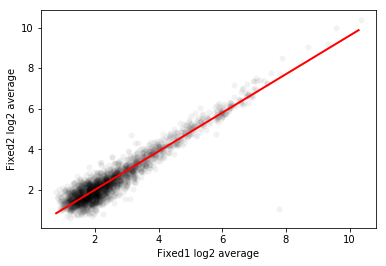

In [121]:
# 
# try the mean of raw expression
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneExpression={}
geneExpression['fixed']={}; geneExpression['fresh']={}
for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    for j in range(len(listOfGenes)): 
        
        geneID=listOfGenes[j]
        value=counts[0,j]
        
        if value > 0:
        
            if i < 11:
                if geneID not in geneExpression['fixed']:
                    geneExpression['fixed'][geneID]=[]
                geneExpression['fixed'][geneID].append(value)

            if i > 11 and i < 23:
                if geneID not in geneExpression['fresh']:
                    geneExpression['fresh'][geneID]=[]
                geneExpression['fresh'][geneID].append(value)        
                
# get observed genes in fixed and fresh
observedGenesFixed=list(geneExpression['fixed'].keys())
observedGenesFresh=list(geneExpression['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh)) 

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    valuesx=geneExpression['fixed'][element]
    valuesy=geneExpression['fresh'][element]
    
    averagex=numpy.log2(numpy.mean(valuesx))
    averagey=numpy.log2(numpy.mean(valuesy))
    
    if len(valuesx) > 5 and len(valuesy) > 5:
        x.append(averagex); y.append(averagey)

print(len(x),len(y))

# regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# spearmanr
rho,pvalue=scipy.stats.spearmanr(x,y)
print('spearman',rho,pvalue)

# model
satx=numpy.arange(min(x),max(x),0.1)
saty=slope*satx + intercept

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.plot(satx,saty,'-r',lw=2)
matplotlib.pyplot.xlabel('Fixed1 log2 average')
matplotlib.pyplot.ylabel('Fixed2 log2 average')

# RANKS

81
10891
[1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 3, 1, 0, 6, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 3, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1]
9526
rank of mm10_Ftl1 0.4583333333333333 0.9649122807017544
3003 3003
	 regression results:
		 slope 0.6813482712421457
		 intercept 376.50239300293197
		 r_value 0.8042464671552217
		 pvalue 0.0
		 std_err 0.009190724224663264
correlation 0.7859556509930564 0.0


Text(0, 0.5, 'Fresh mean rank')

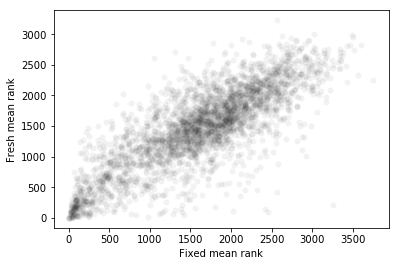

In [109]:
# 
# try the log2(1-rank) of geometric mean
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneRanks={}
geneRanks['fixed']={}; geneRanks['fresh']={}

for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    nonZeroCellExression={}
    for j in range(len(listOfGenes)): 
        count=counts[0,j]
        if count > 0:
            nonZeroCellExression[listOfGenes[j]]=count
    sortedGenes=sorted(nonZeroCellExression,key=nonZeroCellExression.get,reverse=True)
    
    if '-1' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fixed']:
                geneRanks['fixed'][geneID]=[]
            geneRanks['fixed'][geneID].append(sortedGenes.index(geneID))
            
    if '-2' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fresh']:
                geneRanks['fresh'][geneID]=[]
            geneRanks['fresh'][geneID].append(sortedGenes.index(geneID))

print(geneRanks['fresh']['mm10_Ftl1'])
print(geneRanks['fixed']['mm10_Ftl1'])
    
# get observed genes in fixed and fresh
observedGenesFixed=list(geneRanks['fixed'].keys())
observedGenesFresh=list(geneRanks['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh))
print(len(commonGenesObserved))

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    
    ranksx=geneRanks['fixed'][element]
    ranksy=geneRanks['fresh'][element]
    
    averageRankx=numpy.mean(ranksx)
    averageRanky=numpy.mean(ranksy)
        
    if len(ranksx) > 10 and len(ranksy) > 10:
        x.append(averageRankx); y.append(averageRanky)
    
    if element == 'mm10_Ftl1':
        print('rank of mm10_Ftl1',averageRankx,averageRanky)
    
print(len(x),len(y))

# regression
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# correlation
rho,pvalue=scipy.stats.spearmanr(x,y)
print('correlation',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.xlabel('Fixed mean rank')
matplotlib.pyplot.ylabel('Fresh mean rank')

81
10891
[1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 3, 1, 0, 6, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 3, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1]
9526
rank of mm10_Ftl1 0.4583333333333333 0.9649122807017544
9526 9526
	 regression results:
		 slope 0.6335520619730731
		 intercept 496.2820539351096
		 r_value 0.7874703561165531
		 pvalue 0.0
		 std_err 0.0050812151307663405
correlation 0.7767743186817297 0.0


Text(0, 0.5, 'Fresh mean rank')

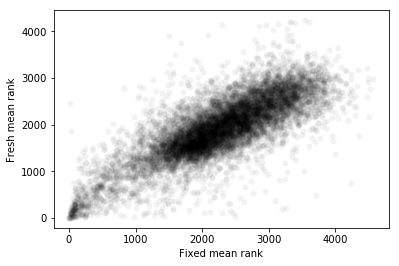

In [84]:
# 
# try the log2(1-rank) of geometric mean
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneRanks={}
geneRanks['fixed']={}; geneRanks['fresh']={}

for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    nonZeroCellExression={}
    for j in range(len(listOfGenes)): 
        count=counts[0,j]
        if count > 0:
            nonZeroCellExression[listOfGenes[j]]=count
    sortedGenes=sorted(nonZeroCellExression,key=nonZeroCellExression.get,reverse=True)
    
    if '-1' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fixed']:
                geneRanks['fixed'][geneID]=[]
            geneRanks['fixed'][geneID].append(sortedGenes.index(geneID))
            
    if '-2' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fresh']:
                geneRanks['fresh'][geneID]=[]
            geneRanks['fresh'][geneID].append(sortedGenes.index(geneID))

print(geneRanks['fresh']['mm10_Ftl1'])
print(geneRanks['fixed']['mm10_Ftl1'])
    
# get observed genes in fixed and fresh
observedGenesFixed=list(geneRanks['fixed'].keys())
observedGenesFresh=list(geneRanks['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh))
print(len(commonGenesObserved))

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    
    ranksx=geneRanks['fixed'][element]
    ranksy=geneRanks['fresh'][element]
    
    averageRankx=numpy.mean(ranksx)
    averageRanky=numpy.mean(ranksy)
    
    x.append(averageRankx); y.append(averageRanky)
    
    if element == 'mm10_Ftl1':
        print('rank of mm10_Ftl1',averageRankx,averageRanky)
    
print(len(x),len(y))

# regression
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# correlation
rho,pvalue=scipy.stats.spearmanr(x,y)
print('correlation',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.xlabel('Fixed mean rank')
matplotlib.pyplot.ylabel('Fresh mean rank')

81
10891
[1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 3, 1, 0, 6, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 3, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1]
9526
rank of mm10_Ftl1 0.0 0.0
	 regression results:
		 slope 0.6223030904520565
		 intercept 505.9859143078693
		 r_value 0.7733026720864152
		 pvalue 0.0
		 std_err 0.005228262546733319
correlation 0.7586644755747739 0.0


Text(0, 0.5, 'Fresh mean rank')

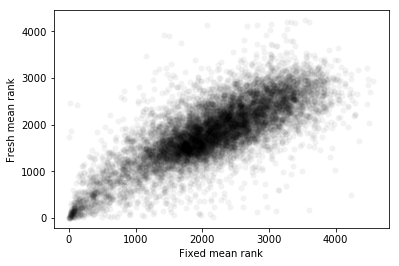

In [88]:
# 
# try the log2(1-rank) of geometric mean
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneRanks={}
geneRanks['fixed']={}; geneRanks['fresh']={}

for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    nonZeroCellExression={}
    for j in range(len(listOfGenes)): 
        count=counts[0,j]
        if count > 0:
            nonZeroCellExression[listOfGenes[j]]=count
    sortedGenes=sorted(nonZeroCellExression,key=nonZeroCellExression.get,reverse=True)
    
    if '-1' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fixed']:
                geneRanks['fixed'][geneID]=[]
            geneRanks['fixed'][geneID].append(sortedGenes.index(geneID))
            
    if '-2' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fresh']:
                geneRanks['fresh'][geneID]=[]
            geneRanks['fresh'][geneID].append(sortedGenes.index(geneID))

print(geneRanks['fresh']['mm10_Ftl1'])
print(geneRanks['fixed']['mm10_Ftl1'])
    
# get observed genes in fixed and fresh
observedGenesFixed=list(geneRanks['fixed'].keys())
observedGenesFresh=list(geneRanks['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh))
print(len(commonGenesObserved))

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    
    ranksx=geneRanks['fixed'][element]
    ranksy=geneRanks['fresh'][element]
    
    averageRankx=scipy.stats.mstats.gmean(ranksx)
    averageRanky=scipy.stats.mstats.gmean(ranksy)
    
    x.append(averageRankx); y.append(averageRanky)
    
    if element == 'mm10_Ftl1':
        print('rank of mm10_Ftl1',averageRankx,averageRanky)

# regression
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# correlation
rho,pvalue=scipy.stats.spearmanr(x,y)
print('correlation',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.xlabel('Fixed mean rank')
matplotlib.pyplot.ylabel('Fresh mean rank')

81
10891
[1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 2, 1, 3, 1, 0, 6, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 3, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1]
[0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 1]
9526
rank of mm10_Ftl1 0.0 1.0
	 regression results:
		 slope 0.607583007615205
		 intercept 557.5715250881458
		 r_value 0.7680108658778264
		 pvalue 0.0
		 std_err 0.005191643328924737
correlation 0.7485831604681696 0.0


Text(0, 0.5, 'Fresh mean rank')

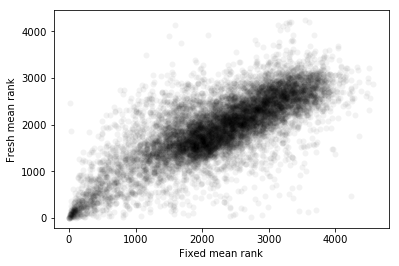

In [89]:
# 
# try the log2(1-rank) of geometric mean
# 

allCellIDs=adata.obs_names.tolist()
listOfGenes=adata.raw.var_names.tolist()

print(len(allCellIDs))
print(len(listOfGenes))

geneRanks={}
geneRanks['fixed']={}; geneRanks['fresh']={}

for i in range(len(allCellIDs)):

    values=adata.raw[i,:].X
    counts=numpy.expm1(values)
    
    nonZeroCellExression={}
    for j in range(len(listOfGenes)): 
        count=counts[0,j]
        if count > 0:
            nonZeroCellExression[listOfGenes[j]]=count
    sortedGenes=sorted(nonZeroCellExression,key=nonZeroCellExression.get,reverse=True)
    
    if '-1' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fixed']:
                geneRanks['fixed'][geneID]=[]
            geneRanks['fixed'][geneID].append(sortedGenes.index(geneID))
            
    if '-2' in allCellIDs[i]:
        for geneID in sortedGenes:
            if geneID not in geneRanks['fresh']:
                geneRanks['fresh'][geneID]=[]
            geneRanks['fresh'][geneID].append(sortedGenes.index(geneID))

print(geneRanks['fresh']['mm10_Ftl1'])
print(geneRanks['fixed']['mm10_Ftl1'])
    
# get observed genes in fixed and fresh
observedGenesFixed=list(geneRanks['fixed'].keys())
observedGenesFresh=list(geneRanks['fresh'].keys())
commonGenesObserved=list(set(observedGenesFixed) & set(observedGenesFresh))
print(len(commonGenesObserved))

# generate variables for plot
x=[]; y=[]

for element in commonGenesObserved:
    
    ranksx=geneRanks['fixed'][element]
    ranksy=geneRanks['fresh'][element]
    
    averageRankx=numpy.median(ranksx)
    averageRanky=numpy.median(ranksy)
    
    x.append(averageRankx); y.append(averageRanky)
    
    if element == 'mm10_Ftl1':
        print('rank of mm10_Ftl1',averageRankx,averageRanky)

# regression
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(x,y)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# correlation
rho,pvalue=scipy.stats.spearmanr(x,y)
print('correlation',rho,pvalue)

# plot
matplotlib.pyplot.plot(x,y,'ok',alpha=0.05,mew=0)
matplotlib.pyplot.xlabel('Fixed mean rank')
matplotlib.pyplot.ylabel('Fresh mean rank')